In [32]:
import io
import os
import json
from tqdm import tqdm
import chess
import numpy as np
from chess.pgn import read_game
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_files = []
for root, _, subpaths in os.walk('games_data_pgns/'):
    for sp in subpaths:
        if sp[-3:] == 'pgn':
            all_files.append(root + '/' + sp)

In [3]:
print('Total Files to analyse:', len(all_files))

Total Files to analyse: 1428


In [4]:
total_games_count = 0
all_games_meta = []
duplicate_games_count = 0

In [5]:
all_files[0]

'games_data_pgns/openings/RuyLopezAntiMarshall.pgn'

In [6]:
games = read_game(open('games_data_pgns/openings/RuyLopezAntiMarshall.pgn'))

In [97]:
def count_games(fpath):
    count = 0
    all_lines = open(fpath, 'r', encoding='latin').readlines()
    this_game = ''
    for line_idx, line in enumerate(all_lines):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            count += 1
            this_game = ''
    return count

def load_data(fpath, ret_len=False):
    game_strings = []
#     print(fpath)
    all_lines = open(fpath, 'r', encoding='latin').readlines()
    this_game = ''
    for line_idx, line in enumerate(all_lines):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            game_strings.append(str(this_game))
            this_game = ''
    if ret_len:
        return len(game_strings)
    game_headers = [read_game(io.StringIO(gs)).headers for gs in game_strings]
    return game_headers

In [98]:
all_games_count = 0
for idx in tqdm(range(len(all_files))):
    all_games_count += count_games(all_files[idx])

100%|██████████| 1428/1428 [00:52<00:00, 27.15it/s] 

In [99]:
print('Total Number of Games (possible duplicates)', all_games_count)

Total Number of Games (possible duplicates) 3112358


In [8]:
all_games = []
for idx in tqdm(range(len(all_files))):
#     print(all_files[idx])
    if 'events' in all_files[idx]:
        all_games.extend(load_data(all_files[idx]))

100%|██████████| 1428/1428 [04:39<00:00,  5.10it/s] 


In [76]:
years = [] # this is the list for all the things that happened year on year
white_elos = []
black_elos = []
results = []

unavain = []
for game in all_games:
    year = game['Date'].split('.')[0] if 'Date' in game else 0
    year = 0 if year == '????' else int(year)
    be = int(game['BlackElo']) if 'BlackElo' in game and game['BlackElo'] else 0
    we = int(game['WhiteElo']) if 'WhiteElo' in game and game['WhiteElo'] else 0
    
    years.append(year)
    white_elos.append(we)
    black_elos.append(be)
    results.append(game['Result'])

In [77]:
cnt_years = Counter(years)
cnt_white_elos = Counter(white_elos)
cnt_black_elos = Counter(black_elos)
cnt_results = Counter(results)

In [78]:
year_ = [y[0] for y in cnt_years.most_common()]
count_ = [y[1] for y in cnt_years.most_common()]

In [95]:
white_elo_won = 0 # white had greater elo and won
black_elo_won = 0 # black had greater elo and won
white_elo_lost = 0 # white had greater elo and lost
black_elo_lost = 0 # black had greater elo and lost
white_elo_draw = 0 # white had greater elo and draw
black_elo_draw = 0 # black had greater elo and draw
for we, be, res in zip(white_elos, black_elos, results):
    if not we or not be:
        continue
    white_elo_won += 1 if we > be and res == '1-0' else 0
    black_elo_won += 1 if be > we and res == '0-1' else 0
    white_elo_lost += 1 if we > be and res == '0-1' else 0
    black_elo_lost += 1 if be > we and res == '1-0' else 0
    white_elo_draw += 1 if we > be and res == '1/2-1/2' else 0
    black_elo_draw += 1 if be > we and res == '1/2-1/2' else 0
    
print('white_elo_won:', white_elo_won)
print('black_elo_won:', black_elo_won)
print('white_elo_lost:', white_elo_lost)
print('black_elo_lost:', black_elo_lost)
print('white_elo_draw:', white_elo_draw)
print('black_elo_draw:', black_elo_draw)

total_win = white_elo_won + black_elo_won
total_loss = white_elo_lost + black_elo_lost
total_draw = white_elo_draw + black_elo_draw

print('total_win:', total_win)
print('total_loss:', total_loss)
print('total_draw:', total_draw)

print('total_win [P]:', total_win / (total_win + total_loss + total_draw) * 100)
print('total_loss [P]:', total_loss / (total_win + total_loss + total_draw) * 100)
print('total_draw [P]:', total_draw / (total_win + total_loss + total_draw) * 100)

white_elo_won: 7642
black_elo_won: 4784
white_elo_lost: 2230
black_elo_lost: 3647
white_elo_draw: 9594
black_elo_draw: 10937
total_win: 12426
total_loss: 5877
total_draw: 20531
total_win [P]: 31.997733944481638
total_loss [P]: 15.133645774321472
total_draw [P]: 52.86862028119689


Text(0.5, 0, 'Result')

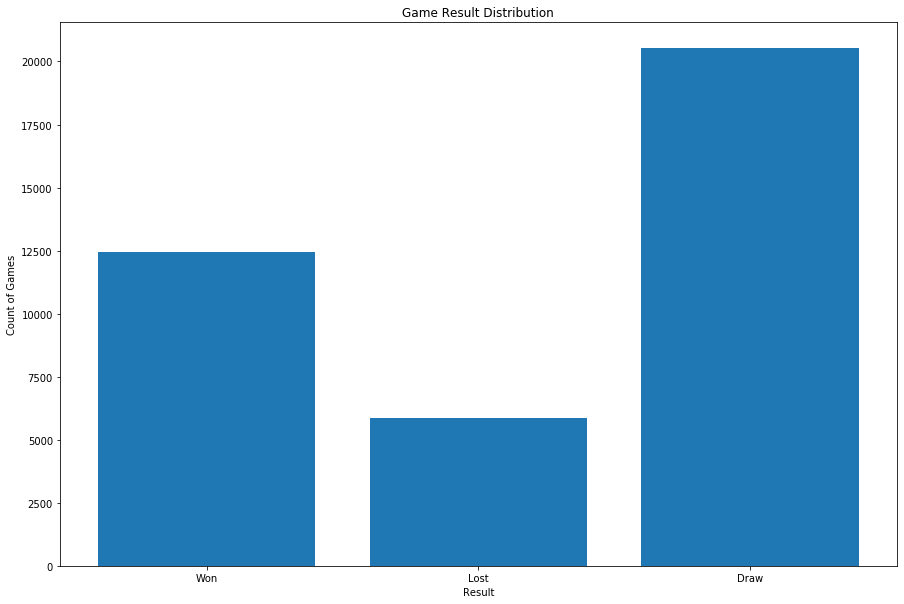

In [91]:
plt.figure(figsize = (15, 10))
plt.bar(
    ['Won', 'Lost', 'Draw'],
    [total_win, total_loss, total_draw],
)
plt.title('Game Result Distribution')
plt.ylabel('Count of Games')
plt.xlabel('Result')